In [1]:
import numpy as np
import os
import sys
from pprint import pprint
from numpy import sin, cos, pi
import numpy.matlib
import random
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point
import shapely.affinity as affinity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import pyomo.environ as pyo
import pyomo.gdp as pyg
from scipy.spatial import ConvexHull
#tf.disable_v2_behavior()  # this line is added to allow placeholder() function to work (does not work in tf2)

2022-01-19 14:57:44.498743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/daittan/catkin_ws/devel/lib:/opt/ros/melodic/lib:/home/daittan/NN-Repair/gurobi912/linux64/lib
2022-01-19 14:57:44.498769: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Introduction

In this code, we generate a neural network that predicts the transformed (rotated) value of the input point.

We then enforce a constraint on the output set such that we require the transformed (rotated) points to stay within a certain box. These constraints can be defined in the form of $Ax < b$. 

The idea is to repair the layers of the original neural network train in order to ensure the following two cases:

1) If true transformed (rotated) points are following the constraint, the predicted transformed (rotated) points are close to the true transformed (rotated) points as well as follow the constraint; and


2) If true transformed (rotated) points are violating the constraint, the predicted transformed (rotated) points are close to the true transformed (rotated) points but also follow the constraint.

#  Generate Data


## Training/Testing Data 

#### Create Data (Affine Transformation)

In [2]:
num_pts = 200
## polygon vertices
poly = Polygon([(1, 1), (4, 1), (4, 4), (1, 4)])
poly2 = Polygon([(2.5, 4.621), (4.624, 2.5), (2.5, 0.3787), (0.3787, 2.5)])  # transformed polygon vertices
x_poly, y_poly = poly.exterior.xy
x_poly2, y_poly2 = poly2.exterior.xy

In [3]:
## generate random points within the input polygon
def random_points_within(pol, num_points):
    min_x, min_y, max_x, max_y = pol.bounds

    gen_points = []

    while len(gen_points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if random_point.within(pol):
            gen_points.append(random_point)

    return gen_points

points_obj = random_points_within(poly, num_pts)
x = np.ones((3, num_pts))     #(x,y,b)

for i in range(num_pts):
    x[0][i] = points_obj[i].x
    x[1][i] = points_obj[i].y


In [4]:
## rotate input points in-place by pi/4 radian
transform1 = np.array([[1, 0, 2.5], [0, 1, 2.5], [0, 0, 1]])  # transformation matrix 1
transform2 = np.array([[1, 0, -2.5], [0, 1, -2.5], [0, 0, 1]])  # transformation matrix 2
rotate = np.array([[cos(pi / 4), -sin(pi / 4), 0], [sin(pi / 4), cos(pi / 4), 0], [0, 0, 1]])  # rotation matrix
y = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), x)

#### Safe Bound

In [5]:
inp = np.array([[1.25, 3.75, 3.75, 1.25],[1.25, 1.25, 3.75, 3.75],[1, 1 , 1, 1]])
out = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), inp)
poly3 = Polygon([(out[0, 0], out[1, 0]), (out[0, 1], out[1, 1]), (out[0, 2], out[1, 2]), (out[0, 3], out[1, 3])])

# get the coordinates of the exterior points of the polytope
ex_points = np.array(poly3.exterior.coords)

# get A and b matrices
hull = ConvexHull(ex_points)
eqs = np.array(hull.equations)
A = eqs[0:eqs.shape[0],0:eqs.shape[1]-1]
b = -eqs[0:eqs.shape[0],-1]
print(A)
print(b)
print(ex_points)

[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
[ 1.25        4.78553391 -2.28553391  1.25      ]
[[2.5        0.73223305]
 [4.26776695 2.5       ]
 [2.5        4.26776695]
 [0.73223305 2.5       ]
 [2.5        0.73223305]]


#### Plot the Genarated Data 

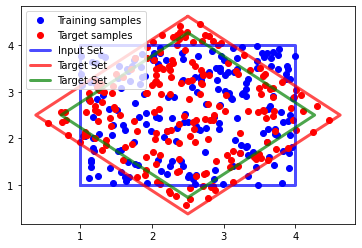

In [6]:
## plot generated data
x_poly3, y_poly3 = poly3.exterior.xy
plt.plot(x[0, :], x[1, :], 'bo', label='Training samples')
plt.plot(y[0, :], y[1, :], 'ro', label='Target samples')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')
plt.plot(x_poly2, y_poly2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.legend(loc="upper left")
plt.show()

## reshape input and outputs into column vectors
#x = np.transpose(x[[0, 1], :])
#y = np.transpose(y[[0, 1], :])
x = np.transpose(x)
y = np.transpose(y)

#### Generate data points around the edge

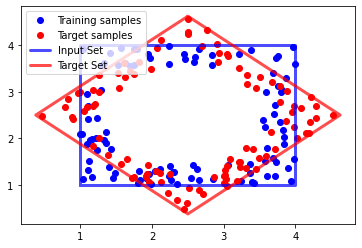

In [7]:
def random_points_edge(poly, num_points, scale = 0.7):
    poly_a = affinity.scale(poly, xfact = scale, yfact = scale)
    gen_points = []
    while len(gen_points) < num_points:
        temp = random_points_within(poly, 1)
        if not temp[0].within(poly_a):
            gen_points.append(temp[0])
    return gen_points

num_points_edge = 100
points_edge = random_points_edge(poly, num_points_edge)
x_edge = np.ones((3, num_points_edge))     #(x,y,b)

for i in range(num_points_edge):
    x_edge[0][i] = points_edge[i].x
    x_edge[1][i] = points_edge[i].y

## rotate input points in-place by pi/4 radian
y_edge = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), x_edge)
    
## plot generated data
plt.plot(x_edge[0, :], x_edge[1, :], 'bo', label='Training samples')
plt.plot(y_edge[0, :], y_edge[1, :], 'ro', label='Target samples')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')
plt.plot(x_poly2, y_poly2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.legend(loc="upper left")
plt.show()
x_edge = np.transpose(x_edge)
y_edge = np.transpose(y_edge)

In [8]:
x = np.append(x, x_edge,axis = 0)
y = np.append(y, y_edge,axis = 0)

#### Training Mini-Batch Generator

In [9]:
print(x.shape)

(300, 3)


In [10]:
class Batch(object):
    def __init__(self, X_col, Y_col, batch_size_val):
        self.X = X_col
        self.Y = Y_col
        self.size = X_col.shape[0]
        self.train_size = batch_size_val
        self.test_size = self.size - batch_size_val

    def getBatch(self):
        values = range(self.size)
        train_dataset, test_dataset = train_test_split(values, train_size=self.train_size, test_size=self.test_size)
        # indices = np.random.choice(range(self.size), self.batch_size)  # sampling with replacement
        return self.X[train_dataset, :], self.Y[train_dataset, :], self.X[test_dataset, :], self.Y[test_dataset, :]
num_pts = x.shape[0]
batch_size = int(0.7 * num_pts)
batch = Batch(x, y, batch_size)

In [11]:
batch_size

210

# 3-Layer NN

## Build 3-Layer NN Model

Here we setup a 3-layer MLP, with the single hidden layer of ReLU activation and train it with gradient descent optimizer to learn the defined affine transformation from the given data. 
$$
\min_{\mathbf{W}^0,\mathbf{W}^1,\mathbf{W}^2,\mathbf{b}^0,\mathbf{b}^1,\mathbf{b}^2}~~\frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^0_n,\mathbf{W}^0,\mathbf{W}^1,\mathbf{b}^0,\mathbf{b}^1)-\mathbf{t}_n||^2_2
$$
$$
\mathbf{W}^0 \mathbf{x}^0 + \mathbf{b}^0 = \mathbf{h}^0
$$
$$
\mathbf{x}^1 = \mathrm{ReLU} (\mathbf{h}^0)
$$
$$
\mathbf{W}^1 \mathbf{x}^1 + \mathbf{b}^1 = \mathbf{h}^1
$$
$$
\mathbf{x}^2 = \mathrm{ReLU} (\mathbf{h}^1)
$$
$$
\mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y}
$$

![NN_original.jpg](NN_original.jpg)


#### Initializing Parameters for MLP Model

In [12]:
num_input = batch.X.shape[1]
num_output = batch.Y.shape[1]
#num_layers_0 = 3
num_hidden_0 = 20
num_hidden_1 = 10
architecture = [num_input, num_hidden_0, num_hidden_1, num_output]
starter_learning_rate = 0.01
regularizer_rate = 0.001

#Create the 3 layers model
# Define Sequential model with 3 layers
model_orig = keras.Sequential(name="3_layer_NN")
model_orig.add(layers.Dense(num_hidden_0,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            input_shape=(3,),
                            name="layer0"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_hidden_1,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            name="layer1"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_output,
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate), 
                            name="output"))

model_orig.summary()
print(model_orig.layers[0].weights)
print(model_orig.layers[0].kernel)

Model: "3_layer_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Dense)               (None, 20)                80        
_________________________________________________________________
layer1 (Dense)               (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 3)                 33        
Total params: 323
Trainable params: 323
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'layer0/kernel:0' shape=(3, 20) dtype=float32, numpy=
array([[-0.46774632, -0.16712049,  0.24076378,  0.4635051 ,  0.2026248 ,
        -0.37836915, -0.01675647,  0.02580595, -0.1709561 ,  0.17109406,
        -0.33615464,  0.05541301, -0.18963695, -0.43016404,  0.23804885,
        -0.24184552,  0.1556899 ,  0.05500972, -0.0008781 ,  0.29871213],
       [-0.46239486, -0.201

2022-01-19 14:57:47.153464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 14:57:47.154058: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/daittan/catkin_ws/devel/lib:/opt/ros/melodic/lib:/home/daittan/NN-Repair/gurobi912/linux64/lib
2022-01-19 14:57:47.154172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/daittan/catkin_ws/devel/lib:/opt/ros/melodic/lib:/home/daittan/NN-Repair/gurobi912/linux64/lib
2022-01-19 14:57:47.154258: W tensorflow/stream_executor/platform/default/dso_loader.c

In [23]:
print(architecture)

[3, 20, 10, 3]


#### Train the model

In [13]:
# define loss 
loss = keras.losses.MeanSquaredError(name='MSE')
#loss = keras.losses.MeanSquaredLogarithmicError(name='MSLE')
optimizer = keras.optimizers.SGD(learning_rate = starter_learning_rate, name='SGD')
model_orig.compile(optimizer = optimizer,
                   loss = loss,
                   metrics=['accuracy'])

In [14]:
x_train, y_train, x_test, y_test = batch.getBatch()
his = model_orig.fit(x_train, y_train, epochs=300, use_multiprocessing = True, verbose = 0)
print("Model Accuracy on Test Data Set")
model_orig.evaluate(x_test,  y_test, verbose=2)


2022-01-19 14:57:47.559956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model Accuracy on Test Data Set
3/3 - 0s - loss: 0.0275 - accuracy: 1.0000


[0.02746358886361122, 1.0]

In [15]:
#w0_orig, b0_orig, w1_orig, b1_orig, w2_orig, b2_orig = s.run([weights_0, bias_0, weights_1, bias_1, weights_2, bias_2])
w0_orig = model_orig.layers[0].kernel.numpy()
b0_orig = model_orig.layers[0].bias.numpy()
w1_orig = model_orig.layers[1].kernel.numpy()
b1_orig = model_orig.layers[1].bias.numpy()
w2_orig = model_orig.layers[2].kernel.numpy()
b2_orig = model_orig.layers[2].bias.numpy()

In [16]:
weights = []
bias = []

for iterate in model_orig.layers:
    print(iterate.output_shape)
    weights.append(iterate.kernel.numpy())
    bias.append(iterate.bias.numpy())





(None, 20)
(None, 10)
(None, 3)


#### Plot Loss Function

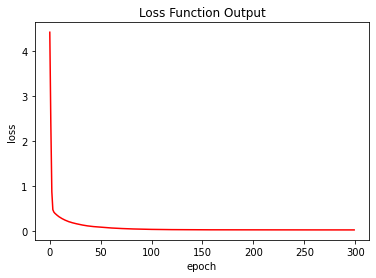

In [17]:

results_train_loss = his.history['loss']
plt.plot(results_train_loss, color='red')
plt.title('Loss Function Output')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [21]:
model_orig.save('tp_1', '/home/daittan/NN-Repair/NN-Repair/')
import pickle

with open("/home/daittan/NN-Repair/NN-Repair/input_output_data_1.pickle", "wb") as data:
    pickle.dump([x_train, y_train, x_test, y_test], data)

INFO:tensorflow:Assets written to: tp_1/assets


#### Plot Trained Model Ouput

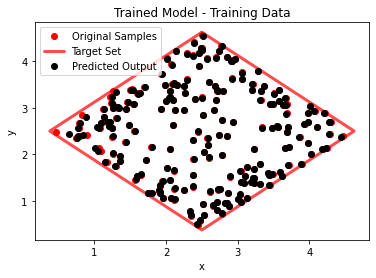

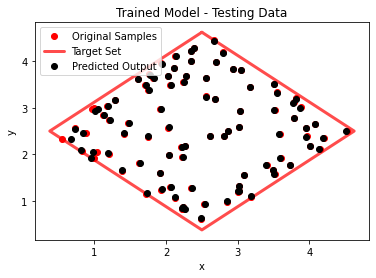

In [18]:
def plot_model(model, x_true, y_true, poly_1, poly_2, arg):
    y_predict = model_orig.predict(x_true)
    
    ## training output
    plt.plot(y_true[:, 0], y_true[:, 1], 'ro', label='Original Samples')
    x_poly_2, y_poly_2 = poly_2.exterior.xy
    plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2,
             label='Target Set')

    ## predicted output
    plt.plot(y_predict[:, 0], y_predict[:, 1], 'ko', label='Predicted Output')
    plt.title(arg)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc="upper left")
    plt.show()
    return y_predict

y_predict_train = plot_model(model_orig, x_train, y_train, poly, poly2, arg='Trained Model - Training Data')
y_predict_test = plot_model(model_orig, x_test, y_test, poly, poly2, arg='Trained Model - Testing Data')

In [19]:
## save data
# import pickle 
# pickle.dump(x_train,open("x_train.dat","wb"))
# pickle.dump(y_predict_train,open("y_predict_train.dat","wb"))
# pickle.dump(y_train,open("y_train.dat","wb"))
# pickle.dump(w_0,open("w_0.dat","wb"))
# pickle.dump(b_0,open("b_0.dat","wb"))
# pickle.dump(w_1,open("w_1.dat","wb"))
# pickle.dump(b_1,open("b_1.dat","wb"))

#### Adversarial sample generator

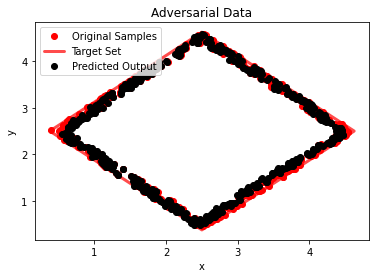

In [20]:
num_points_edge1 = 500
points_edge1 = random_points_edge(poly, num_points_edge1, scale = 0.9)
x_edge1 = np.ones((3, num_points_edge1))     #(x,y,b)

for i in range(num_points_edge1):
    x_edge1[0][i] = points_edge1[i].x
    x_edge1[1][i] = points_edge1[i].y

## rotate input points in-place by pi/4 radian
y_edge1 = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), x_edge1)
x_edge1 = np.transpose(x_edge1)
y_edge1 = np.transpose(y_edge1)

y_new = plot_model(model_orig, x_edge1, y_edge1, poly, poly2, arg='Adversarial Data')

In [21]:
for i in range(y_new.shape[0]):
    point = Point([y_new[i][0], y_new[i][1]])
    if not point.within(poly2):
        print("point: {} is out of bound".format(y_new[i]))

point: [1.5544635  1.3211179  0.97817326] is out of bound
point: [2.426882  4.550319  1.0032785] is out of bound
point: [1.9916769  0.8859586  0.94596875] is out of bound
point: [3.6741917 3.4530125 1.0067644] is out of bound


### Replicate the Original NN

#### Classes (NN with Numpy)

In [22]:
class Dense:
    def __init__(self, nin, nout):
        self.weights = np.random.rand(nin, nout) * 2 - 1
        self.bias = np.random.rand(nout) * 2 - 1
        
    def _relu(self, x):
        return np.maximum(x, 0)
    
    def __call__(self, x, relu=False):
        x = x @ self.weights + self.bias
        if relu:
            x = self._relu(x)
            
        return x

    def set_variables(self, weights=None, bias=None):
        if weights is not None:
            self.weights[:] = weights[:]
            
        if bias is not None:
            self.bias[:] = bias[:]
            
class MLP:
    def __init__(self, nin, uout, uhidden):
        self.num_layer = len(uhidden)+1
        prev = nin
        self.layers = []
        for u in uhidden:
            self.layers.append(Dense(prev, u))
            prev = u
        self.layers.append(Dense(prev, uout))
        
    def __call__(self, x, relu=False):
        
        x1 = self.layers[0](x, relu=True)
        # print(x1.shape)
        for iterate in range(1, self.num_layer-1):
            variable1 = "x"+str(iterate+1)
            variable2 = "x"+str(iterate)
            vars()[variable1] = self.layers[iterate](vars()[variable2], relu=True)
            
        variable_name = "x" + str(self.num_layer-1)
        y = self.layers[self.num_layer-1](vars()[variable_name], relu = True)
        # y = exec("self.layers[{}](x{}, relu = True)".format(self.num_layer-1,self.num_layer-1))
        

        exec_string = ""
        for j in range(1, self.num_layer):
            exec_string = exec_string + "x" + str(j) + ", "
        exec_string = exec_string + "y"
        return tuple(eval(exec_string))

        # if self.num_layer == 2:
        #     x1 = self.layers[0](x, relu=True)
        #     y = self.layers[1](x1, relu=relu)
        #     return x1, y
        
        # if self.num_layer == 3:
        #     x1 = self.layers[0](x, relu=True)
        #     x2 = self.layers[1](x1, relu=True)
        #     y = self.layers[2](x2, relu=relu)
        #     print(x.shape)
        #     print(x1.shape)
        #     print(x2.shape)
        #     print(y.shape)
        #     return x1, x2, y

#### Reconstruct the Original NN to Obtain Diferrent Layer values given Input x0

In [23]:
# print(num_input)
mlp_orig = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_orig.layers[0].weights=w0_orig   
mlp_orig.layers[1].weights=w1_orig  
mlp_orig.layers[2].weights=w2_orig  
mlp_orig.layers[0].bias=b0_orig
mlp_orig.layers[1].bias=b1_orig
mlp_orig.layers[2].bias=b2_orig
a = mlp_orig(x_train, relu=False)
# print(a)
X0_orig_train, X1_orig_train, Y_orig_train = mlp_orig(x_train, relu=False)
X0_orig_test, X1_orig_test, Y_orig_test = mlp_orig(x_test, relu=False)


# print("w0= "+str(w_0))
# print("w1= "+str(w_1))
# print("b0= "+str(b_0))
# print("b1= "+str(b_1))
# print("x_train= "+str(x_train))
# print("hiddel_layer= "+str(h_copy))
# print("y_predicted= "+str(y_copy))
#print(y_predict_train)
#print(Y_orig_train)

## Repair the network with the modification of the last layer

Repairing last layer $\mathbf{W}_{new}^2 \mathbf{x}^2 + \mathbf{b}_{new}^2 = \mathbf{y}$:

\begin{align}
       & \min_{\mathbf{W}^2,\mathbf{b}^2}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^2_n,\mathbf{W}^2,\mathbf{b}^2)-\mathbf{t}_n||^2_2, \\
       & \text{s.t.} & &   \mathbf{W}_{new}^2 \mathbf{x}^2 + \mathbf{b}_{new}^2 = \mathbf{y},\\
       & & & \mathbf{A}\mathbf{y}\leq b.
\end{align}

![repair_last_layer.jpg](repair_last_layer.jpg)

### Build 1 Layer MIP NN

#### classes

In [24]:
class MIPLayer:
    def __init__(self, model, layer_to_repair, uin, uout, weights, bias, param_bounds=(-1, 1)):

        model.nlayers = getattr(model, 'nlayers', 0)
        # print("Model layers = {}".format(model.nlayers))
        self.layer_num = model.nlayers
        self.uin, self.uout = uin, uout

        if model.nlayers == layer_to_repair:
            w_l, b_l = 'w' + str(model.nlayers), 'b' + str(model.nlayers)
        
            setattr(model, w_l, pyo.Var(range(uin), range(uout), domain=pyo.Reals, bounds=param_bounds))
            setattr(model, b_l, pyo.Var(range(uout), domain=pyo.Reals, bounds=param_bounds))
        
            self.w = getattr(model, w_l)
            self.b = getattr(model, b_l)
            self.w_orig = weights
            self.b_orig = bias
        else:
            self.w = weights
            self.b = bias
            
        model.nlayers += 1

        self.model = model
        self.layer_to_repair = layer_to_repair
        
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1),w_b_bound_error=0.5):
        
        self.lout = getattr(self, 'layer_num', 0)+1
        # print("*****************")
        # print(self.lout)
        # print(self.layer_to_repair+1)
        # print("*****************")
        if relu:
            return self._relu_constraints(x, shape, self.lout, output_bounds, w_b_bound_error)
        return self._constraints(x, shape, self.lout, output_bounds, w_b_bound_error)
    
    def _relu_constraints(self, x, shape, l, output_bounds=(-1e1, 1e1), w_b_bound_error = 0.5):
        m, n = shape
        assert n == self.uin
        
        x_l, s_l, theta_l = 'x'+str(l), 's'+str(l), 'theta'+str(l)
        w_l = 'w'+str(l-1)
        b_l = 'b'+str(l-1)

        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, s_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, theta_l, pyo.Var(range(m), range(self.uout), domain=pyo.Binary))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j] - getattr(model, s_l)[i, j]
        
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        
        if l==self.layer_to_repair+1:
            print("Activating mid layer")
            def constraint_bound_w0(model, i, j):
                return(getattr(model, w_l)[i, j]-self.w_orig[i,j] <= w_b_bound_error)
        
            def constraint_bound_w1(model, i, j): 
                return(getattr(model, w_l)[i, j]-self.w_orig[i,j] >= -w_b_bound_error)
        
            def constraint_bound_b0(model, j):
                return(getattr(model, b_l)[j]-self.b_orig[j] <= w_b_bound_error)
        
            def constraint_bound_b1(model, j): 
                return(getattr(model, b_l)[j]-self.b_orig[j] >= -w_b_bound_error)
            
            setattr(self.model, 'w_bounded_constraint0'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w0))
            setattr(self.model, 'w_bounded_constraint1'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w1))
            setattr(self.model, 'b_bounded_constraint0'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_bound_b0))
            setattr(self.model, 'b_bounded_constraint1'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_bound_b1))
        
        def disjuncts(model, i, j):
            return [(getattr(model, theta_l)[i, j] == 0, getattr(model, x_l)[i, j] <= 0),
                    (getattr(model, theta_l)[i, j] == 1, getattr(model, s_l)[i, j] <= 0)]
        
        setattr(self.model, 'disjunction'+str(l), pyg.Disjunction(range(m), range(self.uout), rule=disjuncts))
        return  getattr(self.model, x_l)
        
    def _constraints(self, x, shape, l, output_bounds=(-1e1, 1e1), w_b_bound_error = 0.5):
        m, n = shape
        assert n == self.uin
        if l==self.layer_to_repair+1:
            w_l = 'w'+str(l-1)
            b_l = 'b'+str(l-1)
        x_l = 'x'+str(l)
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.Reals, bounds=output_bounds))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j]

        def constraint_inside0(model, i):
             return(A[0,0]*getattr(model, x_l)[i, 0] + A[0,1]*getattr(model, x_l)[i, 1] - b[0] <= 0)
        
        def constraint_inside1(model, i):
             return(A[1,0]*getattr(model, x_l)[i, 0] + A[1,1]*getattr(model, x_l)[i, 1] - b[1] <= 0)
        
        def constraint_inside2(model, i):
             return(A[2,0]*getattr(model, x_l)[i, 0] + A[2,1]*getattr(model, x_l)[i, 1] - b[2] <= 0)
       
        def constraint_inside3(model, i):
             return(A[3,0]*getattr(model, x_l)[i, 0] + A[3,1]*getattr(model, x_l)[i, 1] - b[3] <= 0)
        
        

        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        setattr(self.model, 'keep_inside_constraint0'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside0))
        setattr(self.model, 'keep_inside_constraint1'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside1))
        setattr(self.model, 'keep_inside_constraint2'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside2))
        setattr(self.model, 'keep_inside_constraint3'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside3))

        if l==self.layer_to_repair+1:
            print("Activating Last layer")
            def constraint_bound_w0(model, i, j):
                return(getattr(model, w_l)[i, j]-self.w_orig[i,j] <= w_b_bound_error)
        
            def constraint_bound_w1(model, i, j): 
                return(getattr(model, w_l)[i, j]-self.w_orig[i,j] >= -w_b_bound_error)
        
            def constraint_bound_b0(model, j):
                return(getattr(model, b_l)[j]-self.b_orig[j] <= w_b_bound_error)
        
            def constraint_bound_b1(model, j): 
                return(getattr(model, b_l)[j]-self.b_orig[j] >= -w_b_bound_error)
            
            setattr(self.model, 'w_bounded_constraint0'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w0))
            setattr(self.model, 'w_bounded_constraint1'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w1))
            setattr(self.model, 'b_bounded_constraint0'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_bound_b0))
            setattr(self.model, 'b_bounded_constraint1'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_bound_b1))
        
        
        
        return getattr(self.model, x_l)

In [25]:
class MIPNNModel:
    def __init__(self, layer_to_repair, architecture, weights, bias, param_bounds=(-1, 1)):
        self.model = pyo.ConcreteModel()
        
        self.model.nlayers = layer_to_repair
        
        self.uin, self.uout = architecture[layer_to_repair-1], architecture[-1]
        uhidden = architecture[layer_to_repair:-1]
        
        self.layers = []
        prev = architecture[layer_to_repair-1]
        print("UHidden = {}".format(uhidden))
        for iterate, u in enumerate(uhidden): 
            self.layers.append(MIPLayer(self.model, layer_to_repair, prev, u, weights[layer_to_repair-1 + iterate], bias[layer_to_repair-1 + iterate], param_bounds))
            prev = u
        self.layers.append(MIPLayer(self.model, layer_to_repair, prev, architecture[-1], weights[-1], bias[-1], param_bounds))
        
        
    def __call__(self, x, shape, w_b_bound_error, relu=False, output_bounds=(-1e1, 1e1)):
        
        m, n = shape
        assert n == self.uin
        
        for layer in self.layers[:-1]:
            x = layer(x, (m, layer.uin), relu=True, output_bounds=output_bounds, w_b_bound_error=w_b_bound_error)
        
        layer = self.layers[-1]
        y = layer(x, (m, layer.uin), relu=relu, output_bounds=output_bounds,w_b_bound_error=w_b_bound_error)
        return y

#### Building 1 Layer

In [26]:
num_samples = X1_orig_train.shape[0]
mip_model_layer3 = MIPNNModel(3, architecture, weights, bias)
y_ = mip_model_layer3(X1_orig_train, (num_samples, num_hidden_1), w_b_bound_error = 1)


model_lay3 = mip_model_layer3.model
pprint(vars(model_lay3))





UHidden = []
Activating Last layer
{'_constructed': True,
 '_ctype': <class 'pyomo.core.base.block.Block'>,
 '_ctypes': {<class 'pyomo.core.base.set.Set'>: [0, 32, 22],
             <class 'pyomo.core.base.var.Var'>: [3, 9, 3],
             <class 'pyomo.core.base.constraint.Constraint'>: [13, 33, 9]},
 '_data': {None: <pyomo.core.base.PyomoModel.ConcreteModel object at 0x7f387821da00>},
 '_decl': {'b3': 5,
           'b3_index': 4,
           'b_bounded_constraint04': 31,
           'b_bounded_constraint04_index': 30,
           'b_bounded_constraint14': 33,
           'b_bounded_constraint14_index': 32,
           'eq_constraint4': 13,
           'eq_constraint4_index': 12,
           'eq_constraint4_index_0': 10,
           'eq_constraint4_index_1': 11,
           'keep_inside_constraint04': 15,
           'keep_inside_constraint04_index': 14,
           'keep_inside_constraint14': 17,
           'keep_inside_constraint14_index': 16,
           'keep_inside_constraint24': 19,
      

In [27]:
print(num_output)

3


#### Final Output and Ojbective

In [28]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, y_train, num_samples, num_output) ## check correctness

# regularization term for weigts
for j in range(num_output):
    cost_expr += regularizer_rate*model_lay3.b3[j]**2
    for i in range(num_hidden_1):
        cost_expr += regularizer_rate*model_lay3.w3[i, j]**2



model_lay3.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay3)
opt = pyo.SolverFactory('gurobi',solver_io="python")

opt.solve(model_lay3, tee=True)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to /tmp/tmpfmc80oop.log
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1536 rows, 663 columns and 6729 nonzeros
Model fingerprint: 0xcf0b9025
Model has 663 quadratic objective terms
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  Objective range  [8e-01, 9e+00]
  QObjective range [2e-03, 2e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e-01, 5e+00]
Presolve removed 486 rows and 12 columns
Presolve time: 0.00s
Presolved: 1050 rows, 1071 columns, 6243 nonzeros
Presolved model has 651 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 21
 AA' NZ     : 5.403e+03
 Factor NZ  : 1.550e+04 (roughly 1 MByte of memory)
 Factor Ops : 2.394e+05 (less than 1 second per iteration)
 Threads    : 1

              

{'Problem': [{'Name': 'unknown', 'Lower bound': 6.200606451542626, 'Upper bound': 6.200606451542626, 'Number of objectives': 1, 'Number of constraints': 1536, 'Number of variables': 663, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 663, 'Number of nonzeros': 6729, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.12', 'Status': 'ok', 'Wallclock time': 0.02645587921142578, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [29]:
#print the model in to a file (can also be saved in an lp format model_lay3.write(XXX.lp))

original_stdout = sys.stdout # Save a reference to the original standard output

with open('last_layer_mip_model_w_bounded.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    model_lay3.pprint()
    sys.stdout = original_stdout # Reset the standard output to its original value

In [30]:
model_lay3.w3.display()

w3 : Size=30, Index=w3_index
    Key    : Lower : Value                   : Upper : Fixed : Stale : Domain
    (0, 0) :    -1 :      0.8841035104676838 :     1 : False : False :  Reals
    (0, 1) :    -1 :     -0.9999999998787348 :     1 : False : False :  Reals
    (0, 2) :    -1 :    0.013545221659895246 :     1 : False : False :  Reals
    (1, 0) :    -1 :                    -0.0 :     1 : False : False :  Reals
    (1, 1) :    -1 :                    -0.0 :     1 : False : False :  Reals
    (1, 2) :    -1 :                    -0.0 :     1 : False : False :  Reals
    (2, 0) :    -1 :                    -0.0 :     1 : False : False :  Reals
    (2, 1) :    -1 :                    -0.0 :     1 : False : False :  Reals
    (2, 2) :    -1 :                    -0.0 :     1 : False : False :  Reals
    (3, 0) :    -1 :      0.9054412106270742 :     1 : False : False :  Reals
    (3, 1) :    -1 :    -0.07503009814921635 :     1 : False : False :  Reals
    (3, 2) :    -1 :     0.06438885

In [31]:
model_lay3.x4.display()

x4 : Size=630, Index=x4_index
    Key      : Lower : Value              : Upper : Fixed : Stale : Domain
      (0, 0) : -10.0 :  3.714566089702476 :  10.0 : False : False :  Reals
      (0, 1) : -10.0 : 2.0400298763560816 :  10.0 : False : False :  Reals
      (0, 2) : -10.0 : 0.9992406473691862 :  10.0 : False : False :  Reals
      (1, 0) : -10.0 : 3.6675048269387087 :  10.0 : False : False :  Reals
      (1, 1) : -10.0 : 2.6574637986124845 :  10.0 : False : False :  Reals
      (1, 2) : -10.0 : 0.9999962519367571 :  10.0 : False : False :  Reals
      (2, 0) : -10.0 : 2.9894176194027366 :  10.0 : False : False :  Reals
      (2, 1) : -10.0 : 1.8003831132229902 :  10.0 : False : False :  Reals
      (2, 2) : -10.0 : 1.0007535716025906 :  10.0 : False : False :  Reals
      (3, 0) : -10.0 : 1.0209610848432007 :  10.0 : False : False :  Reals
      (3, 1) : -10.0 :  2.268541698935403 :  10.0 : False : False :  Reals
      (3, 2) : -10.0 : 1.0003259930919537 :  10.0 : False : False :  R

In [32]:
print(w2_orig) #previously trained nn weights
print(b2_orig) #previously trained nn bias

[[ 0.13659978 -0.6462999   0.004762  ]
 [-0.26295686 -0.64668214 -0.16882043]
 [-0.27984995 -0.15810597  0.02050392]
 [ 0.08931252 -0.55273604  0.5694126 ]
 [ 0.4833518   0.50738984  0.39889482]
 [-0.54964155  0.5719272  -0.23509704]
 [ 0.835656    0.40462542  0.32077888]
 [-0.4473291  -0.44746554  0.4379386 ]
 [ 0.16573004 -0.5767628   0.17631504]
 [ 0.32987046 -0.54720724 -0.48182443]]
[ 0.37416515 -0.00554304  0.13439626]


In [33]:
print(Y_orig_train)

[[3.87505101 1.93567677 1.0432279 ]
 [3.77342877 2.68330035 1.02028381]
 [2.98718587 1.65301427 0.97751358]
 [0.85852301 2.29932012 1.035599  ]
 [3.23118325 2.10714961 0.98843756]
 [1.9657648  1.65976018 0.96402478]
 [4.08968528 2.79611863 1.05297956]
 [2.58471136 2.06878574 0.95796009]
 [1.79834992 1.68392414 0.97328092]
 [2.75654484 2.52625134 0.96584086]
 [3.96627099 2.07642581 1.05049327]
 [1.55223969 3.05045546 1.01562077]
 [2.43991337 3.11753226 0.97075635]
 [4.06894605 2.1061802  1.06386079]
 [3.85730785 3.07919956 1.02006388]
 [1.63072857 3.4021098  1.01911702]
 [3.33302672 1.48018986 1.00765215]
 [3.86614682 2.73719171 1.02834291]
 [2.83531895 3.98434984 0.97041052]
 [3.45333216 1.90754558 1.00938695]
 [4.1435943  2.10160362 1.07996133]
 [2.72684401 2.49985582 0.96451907]
 [3.69754876 1.82013975 1.02387662]
 [1.78518026 1.80301495 0.97653885]
 [3.31681985 3.44428903 0.99109702]
 [1.61531295 3.04525101 1.01221771]
 [2.84607993 4.02485521 0.97091314]
 [2.95700571 1.01588074 0.98

In [34]:
print(y_new.shape)

(500, 3)


In [35]:
# model_lay3 = model_lay3_orig
# y_new = np.zeros((num_samples, num_output))
w2_new = np.zeros((num_hidden_1, num_output))
b2_new = np.zeros((1, num_output))
for i in range(num_samples):
    for j in range(num_output):
        y_new[i, j] = model_lay3.x4[i, j].value
for j in range(num_output):
    b2_new[0, j] = model_lay3.b3[j].value
    for i in range(num_hidden_1):
        w2_new[i, j] = model_lay3.w3[i, j].value
print(w2_new)
print(b2_new)


[[ 8.84103510e-01 -1.00000000e+00  1.35452217e-02]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [ 9.05441211e-01 -7.50300981e-02  6.43888570e-02]
 [ 3.49740588e-01 -8.04900425e-02 -1.39424119e-04]
 [-4.80139562e-01  6.46729096e-01 -1.02025922e-02]
 [ 1.00000000e+00  3.44008728e-01  3.46210755e-02]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00]
 [ 5.49258714e-01  4.52792763e-01 -2.25360087e-03]]
[[-0.62583485  0.08322258  0.90963592]]


#### Build Refined NN 

In [37]:
mlp_lay3 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay3.layers[0].weights=w0_orig   
mlp_lay3.layers[1].weights=w1_orig  
mlp_lay3.layers[2].weights=w2_new  
mlp_lay3.layers[0].bias=b0_orig
mlp_lay3.layers[1].bias=b1_orig
mlp_lay3.layers[2].bias=b2_new

_, _, y_new_train = mlp_lay3(x_train, relu=False)
_, _, y_new_test = mlp_lay3(x_test, relu=False)

(210, 3)
(210, 5)
(210, 4)
(210, 3)
(90, 3)
(90, 5)
(90, 4)
(90, 3)


#### Plot New Results

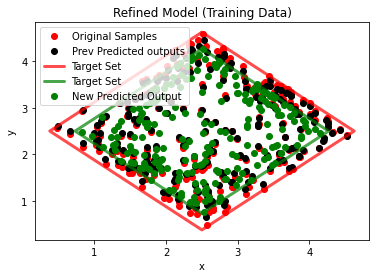

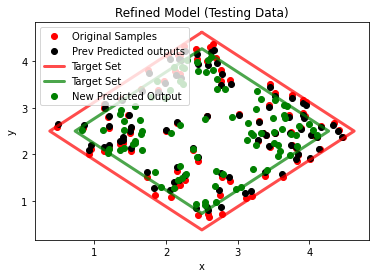

In [38]:
# ## training input
# plt.plot(x_train[:, 0], x_train[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (training)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_train[:, 0], y_train[:, 1], 'ro', label='Original Samples')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new_train[:, 0], y_new_train[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Original Samples')
plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new_test[:, 0], y_new_test[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Testing Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

In [39]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train = squared_sum(y_train, y_new_train, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test = squared_sum(y_test, y_new_test, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Repaired NN (Last Layer)",round(MSE_new_nn_train,5),round(MSE_new_nn_test,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.linalg.norm(w2_new-w2_orig)
bias_error = np.linalg.norm(b2_new-b2_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))

MSE,Training Data,Testing Data
Original NN,0.00681,0.00604
Repaired NN (Last Layer),0.04747,0.05472


weight_error: 0.756354110619297
bias_error: 0.5224780574541605


## Repair the network with the modification of the second layer

In the second layer:
$$
\mathbf{W}^1 \mathbf{X}^1 + \mathbf{b}^1 = \mathbf{H}^1,
$$
$$
\mathbf{X}^2 = \mathrm{ReLU} (\mathbf{H}^1),
$$
optimizing:

\begin{align}
       & \min_{\mathbf{W}^1,\mathbf{b}^1}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^1_n,\mathbf{W}^1,\mathbf{b}^1)-\mathbf{t}_n||^2_2, \\
       & \text{s.t.} & &   \mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y},\\
       & & & \mathbf{A}\mathbf{y}\leq b,\\
       & & & \sum_j w_{ij}^1 x_{jn}^1 + b_i^1 = x_{in}^2 - s_{in}^2, &&&&n=1,\cdots,N,~i=1,\cdots,c,~\mbox{and }j=1,\cdots,q,\\
       & & & x_{in}^2, s_{in}^2 \ge 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2 \in \{0, 1\}, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=0 \rightarrow x_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=1 \rightarrow s_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,
\end{align}
, where $N$, $c$, and $q$ are the number of samples, the number of hidden nodes, and the number of inputs, respectively.   

![repair_second_layer.jpg](repair_second_layer.jpg)

### Replicate the Original NN

#### Classes (NN with Numpy)

In [40]:

num_samples = X1_orig_train.shape[0]
mip_model_layer2 = MIPNNModel(2, architecture, weights, bias)
# y_ = mip_model_layer2(X1_orig_train, (num_samples, num_hidden_1))
y_ = mip_model_layer2(np.round(X0_orig_train,4), (num_samples, num_hidden_0), w_b_bound_error=1)

# print(y_)

model_lay2 = mip_model_layer2.model
pprint(vars(model_lay2))
#print(mip_model_layer3.model.eq_constraint1[(0,0)])





UHidden = [4]
Activating mid layer
{'_constructed': True,
 '_ctype': <class 'pyomo.core.base.block.Block'>,
 '_ctypes': {<class 'pyomo.core.base.set.Set'>: [0, 53, 37],
             <class 'pyomo.core.base.var.Var'>: [3, 42, 6],
             <class 'pyomo.core.base.constraint.Constraint'>: [21, 54, 10],
             <class 'pyomo.gdp.disjunct.Disjunct'>: [38, 38, 1],
             <class 'pyomo.gdp.disjunct.Disjunction'>: [37, 37, 1]},
 '_data': {None: <pyomo.core.base.PyomoModel.ConcreteModel object at 0x7fe200201b80>},
 '_decl': {'b2': 5,
           'b2_index': 4,
           'b_bounded_constraint03': 31,
           'b_bounded_constraint03_index': 30,
           'b_bounded_constraint13': 33,
           'b_bounded_constraint13_index': 32,
           'disjunction3': 37,
           'disjunction3_disjuncts': 38,
           'disjunction3_index': 36,
           'disjunction3_index_0': 34,
           'disjunction3_index_1': 35,
           'eq_constraint3': 21,
           'eq_constraint3_index

#### Building the middle layer with the fixed weights for the final layer

In [41]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, np.round(y_train,4), num_samples, num_output) ## check correctness


#### Final Output and Ojbective

In [50]:


# regularization term for weigts
for j in range(num_hidden_1):
    cost_expr += regularizer_rate*model_lay2.b2[j]**2
    for i in range(num_hidden_0):
        cost_expr += regularizer_rate*model_lay2.w2[i, j]**2



model_lay2.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay2)
opt = pyo.SolverFactory('gurobi')
opt.options['timelimit'] = 1000
opt.options['mipgap'] = 0.04
opt.solve(model_lay2, tee=True)


    'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Academic license - for non-commercial use only - expires 2021-12-31
Using license file /home/daittan/gurobi.lic
Read LP format model from file /tmp/tmp73_t5m3h.pyomo.lp
Reading time = 0.02 seconds
: 8239 rows, 4855 columns, 19163 nonzeros
Changed value of parameter timelimit to 1000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter mipgap to 0.04
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 8239 rows, 4855 columns and 19163 nonzeros
Model fingerprint: 0x9ee27533
Model has 654 quadratic objective terms
Variable types: 2

{'Problem': [{'Name': '', 'Lower bound': 7.602453683251042, 'Upper bound': 9.362535767710769, 'Number of objectives': 1, 'Number of constraints': 8239, 'Number of variables': 4855, 'Number of binary variables': 2520, 'Number of integer variables': 2520, 'Number of continuous variables': 2335, 'Number of nonzeros': 19163, 'Sense': 'minimize'}], 'Solver': [{'Status': 'aborted', 'Return code': '0', 'Message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Termination condition': 'maxTimeLimit', 'Termination message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Wall time': '1000.0074470043182', 'Error rc': 0, 'Time': 1000.2416758537292}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [51]:
#print the model in to a file (can also be saved in an lp format model_lay3.write(XXX.lp))

original_stdout = sys.stdout # Save a reference to the original standard output

with open('second_layer_mip_model_w_bounded.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    model_lay2.pprint()
    sys.stdout = original_stdout # Reset the standard output to its original value

In [52]:
model_lay2.w2.display()

w2 : Size=20, Index=w2_index
    Key    : Lower : Value                  : Upper : Fixed : Stale : Domain
    (0, 0) :    -1 :                    0.0 :     1 : False : False :  Reals
    (0, 1) :    -1 :                    0.0 :     1 : False : False :  Reals
    (0, 2) :    -1 :                    0.0 :     1 : False : False :  Reals
    (0, 3) :    -1 :                    0.0 :     1 : False : False :  Reals
    (1, 0) :    -1 :    0.26149911980415574 :     1 : False : False :  Reals
    (1, 1) :    -1 :  6.526112983351595e-12 :     1 : False : False :  Reals
    (1, 2) :    -1 :    -0.8837642818689346 :     1 : False : False :  Reals
    (1, 3) :    -1 :    -0.5708217840015085 :     1 : False : False :  Reals
    (2, 0) :    -1 :   -0.11740370541179457 :     1 : False : False :  Reals
    (2, 1) :    -1 : 1.2818489759230944e-13 :     1 : False : False :  Reals
    (2, 2) :    -1 :    0.17983645575331353 :     1 : False : False :  Reals
    (2, 3) :    -1 :     0.8889354625441873 :  

In [53]:
model_lay2.b2.display()

b2 : Size=4, Index=b2_index
    Key : Lower : Value                  : Upper : Fixed : Stale : Domain
      0 :    -1 :                    1.0 :     1 : False : False :  Reals
      1 :    -1 : -6.674631009545489e-13 :     1 : False : False :  Reals
      2 :    -1 :     0.7209800422548005 :     1 : False : False :  Reals
      3 :    -1 :    -0.2968136563436997 :     1 : False : False :  Reals


In [54]:
print(w1_orig) #previously trained nn weights

[[-0.7818958  -0.0629504  -0.27309287  0.48521212]
 [-0.081514    0.76438016  0.11623572 -0.3648938 ]
 [-0.4211869  -0.74604267  0.19803168  0.97965455]
 [-0.7171509   0.4450383   1.0691075   0.01526158]
 [-0.00613869  0.58575755  0.6183667   0.05143353]]


In [55]:
model_lay2.x4.display()

x4 : Size=630, Index=x4_index
    Key      : Lower : Value              : Upper : Fixed : Stale : Domain
      (0, 0) : -10.0 :  2.373552243985653 :  10.0 : False : False :  Reals
      (0, 1) : -10.0 : 4.0605837110503495 :  10.0 : False : False :  Reals
      (0, 2) : -10.0 : 1.0912914396065838 :  10.0 : False : False :  Reals
      (1, 0) : -10.0 : 2.5930596900594063 :  10.0 : False : False :  Reals
      (1, 1) : -10.0 :  3.685905295788323 :  10.0 : False : False :  Reals
      (1, 2) : -10.0 : 1.0730158876574731 :  10.0 : False : False :  Reals
      (2, 0) : -10.0 :  2.846964760063032 :  10.0 : False : False :  Reals
      (2, 1) : -10.0 :  1.481218571971181 :  10.0 : False : False :  Reals
      (2, 2) : -10.0 : 0.9926340542350338 :  10.0 : False : False :  Reals
      (3, 0) : -10.0 :  3.477430369143802 :  10.0 : False : False :  Reals
      (3, 1) : -10.0 : 2.3815147380927946 :  10.0 : False : False :  Reals
      (3, 2) : -10.0 : 1.0160011562979225 :  10.0 : False : False :  R

In [56]:
print(Y_orig_train)

[[2.36109511 4.23929335 1.10508063]
 [2.61760153 3.82323359 1.08548806]
 [2.92581598 1.41134578 0.90709104]
 [3.65551987 2.37194643 1.02501935]
 [3.35726462 3.43398933 1.09463619]
 [3.70882185 1.70511825 0.97394209]
 [3.20154415 1.53017736 0.93187787]
 [3.66712739 3.31534734 1.10206642]
 [3.09605309 3.57697065 1.09185261]
 [1.05985198 2.16835578 0.86579392]
 [2.59859844 2.16878286 0.95044433]
 [1.87391716 3.5798594  1.0248812 ]
 [2.58395415 1.21274389 0.87220668]
 [1.53534987 2.03603674 0.88122469]
 [1.93245057 1.70833446 0.87651975]
 [4.01142328 3.0425307  1.09890307]
 [2.55865729 2.71739917 0.99268198]
 [0.99172603 2.45603851 0.88534792]
 [4.06967296 2.70154054 1.07448845]
 [1.0235822  2.28557919 0.8732937 ]
 [2.1141088  1.42067204 0.86321054]
 [2.0973806  4.06507151 1.07646821]
 [2.34887696 1.60580611 0.89111501]
 [2.12698229 1.59616054 0.87813177]
 [2.24160191 1.88578453 0.9078922 ]
 [3.75241278 2.14728292 1.01215135]
 [2.39396391 1.00566747 0.84498738]
 [3.70257246 2.11827639 1.00

In [57]:
X2_new = np.zeros((num_samples,num_output))
w1_new = np.zeros((num_hidden_0,num_hidden_1))
b1_new = np.zeros((1,num_hidden_1))
for i in range(num_samples):
    for j in range(num_output):
        X2_new[i, j] = model_lay2.x4[i, j].value
for j in range(num_hidden_1):
    b1_new[0, j] = model_lay2.b2[j].value
    for i in range(num_hidden_0):
        w1_new[i, j] = model_lay2.w2[i, j].value
print(w1_new)
print(b1_new)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.61499120e-01  6.52611298e-12 -8.83764282e-01 -5.70821784e-01]
 [-1.17403705e-01  1.28184898e-13  1.79836456e-01  8.88935463e-01]
 [-2.41523096e-01  0.00000000e+00  8.96413079e-01  4.79531470e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.00000000e+00 -6.67463101e-13  7.20980042e-01 -2.96813656e-01]]


#### Build Refined NN


In [58]:
mlp_lay2 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay2.layers[0].weights=w0_orig   
mlp_lay2.layers[1].weights=w1_new  
mlp_lay2.layers[2].weights=w2_orig  
mlp_lay2.layers[0].bias=b0_orig
mlp_lay2.layers[1].bias=b1_new
mlp_lay2.layers[2].bias=b2_orig

_, _, y_new2_train = mlp_lay2(x_train, relu=False)
_, _, y_new2_test = mlp_lay2(x_test, relu=False)


(210, 3)
(210, 5)
(210, 4)
(210, 3)
(90, 3)
(90, 5)
(90, 4)
(90, 3)


#### Plot New Results


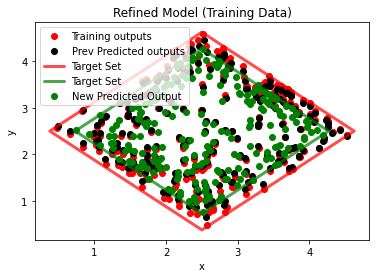

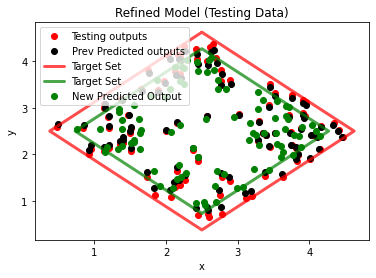

In [59]:
# ## training input
# plt.plot(x_train[:, 0], x_train[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (training)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_train[:, 0], y_train[:, 1], 'ro', label='Training outputs')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new2_train[:, 0], y_new2_train[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Testing outputs')
plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new2_test[:, 0], y_new2_test[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Testing Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

In [60]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train = squared_sum(y_train, y_new2_train, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test = squared_sum(y_test, y_new2_test, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Modified NN",round(MSE_new_nn_train,5),round(MSE_new_nn_test,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.linalg.norm(w1_new-w1_orig)
bias_error = np.linalg.norm(b1_new-b1_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))

MSE,Training Data,Testing Data
Original NN,0.00681,0.00604
Modified NN,0.04247,0.047


weight_error: 2.123781069073283
bias_error: 1.0934577525201803


## Repair the network with the modification of the first layer

In the first layer:
$$
\mathbf{W}^0 \mathbf{X}^0 + \mathbf{b}^0 = \mathbf{H}^0,
$$
$$
\mathbf{X}^1 = \mathrm{ReLU} (\mathbf{H}^0),
$$
optimizing:

\begin{align}
       & \min_{\mathbf{W}^0,\mathbf{b}^0}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^0_n,\mathbf{W}^0,\mathbf{b}^0)-\mathbf{t}_n||^2_2, \\ \\
       & \text{s.t.} & &   \mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y},\\
       & & & \mathbf{A}\mathbf{y}\leq b,\\ \\
       & & & \sum_j w_{ij}^0 x_{jn}^0 + b_i^0 = x_{in}^1 - s_{in}^1, &&&&n=1,\cdots,N,~i=1,\cdots,c,~\mbox{and }j=1,\cdots,q,\\
       & & & x_{in}^1, s_{in}^1 \ge 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^1 \in \{0, 1\}, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^1=0 \rightarrow x_{in}^1 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^1=1 \rightarrow s_{in}^1 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\ \\
       & & & \sum_j w_{ij}^1 x_{jn}^1 + b_i^1 = x_{in}^2 - s_{in}^2, &&&&n=1,\cdots,N,~i=1,\cdots,c,~\mbox{and }j=1,\cdots,q,\\
       & & & x_{in}^2, s_{in}^2 \ge 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2 \in \{0, 1\}, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=0 \rightarrow x_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=1 \rightarrow s_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,
\end{align}
, where $N$, $c$, and $q$ are the number of samples, the number of hidden nodes, and the number of inputs, respectively.   

![repair_first_layer.jpg](repair_first_layer.jpg)

### Replicate the Original NN

#### Classes (NN with Numpy)

#### Building the middle layer with the fixed weights for the final layer

In [61]:
num_samples = X1_orig_train.shape[0]
mip_model_layer1 = MIPNNModel(1, architecture, weights, bias)
y_ = mip_model_layer1(np.round(x_train,4), (num_samples, num_input), w_b_bound_error=0.5)


model_lay1 = mip_model_layer1.model
pprint(vars(model_lay1))





UHidden = [5, 4]
Activating mid layer
{'_constructed': True,
 '_ctype': <class 'pyomo.core.base.block.Block'>,
 '_ctypes': {<class 'pyomo.core.base.set.Set'>: [0, 74, 52],
             <class 'pyomo.core.base.var.Var'>: [3, 63, 9],
             <class 'pyomo.core.base.constraint.Constraint'>: [21, 75, 11],
             <class 'pyomo.gdp.disjunct.Disjunct'>: [38, 59, 2],
             <class 'pyomo.gdp.disjunct.Disjunction'>: [37, 58, 2]},
 '_data': {None: <pyomo.core.base.PyomoModel.ConcreteModel object at 0x7fe2002f3a80>},
 '_decl': {'b1': 5,
           'b1_index': 4,
           'b_bounded_constraint02': 31,
           'b_bounded_constraint02_index': 30,
           'b_bounded_constraint12': 33,
           'b_bounded_constraint12_index': 32,
           'disjunction2': 37,
           'disjunction2_disjuncts': 38,
           'disjunction2_index': 36,
           'disjunction2_index_0': 34,
           'disjunction2_index_1': 35,
           'disjunction3': 58,
           'disjunction3_disjun

#### Final Output and Ojbective

In [63]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, np.round(y_train,4), num_samples, num_output) ## check correctness

# regularization term for weigts
for j in range(num_hidden_0):
    cost_expr += regularizer_rate*model_lay1.b1[j]**2
    for i in range(num_input):
        cost_expr += regularizer_rate*model_lay1.w1[i, j]**2



model_lay1.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay1)
opt = pyo.SolverFactory('gurobi')
opt.options['timelimit'] = 1000
opt.options['mipgap'] = 0.04
opt.solve(model_lay1, tee=True)

    'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Academic license - for non-commercial use only - expires 2021-12-31
Using license file /home/daittan/gurobi.lic
Read LP format model from file /tmp/tmpbrkez2jn.pyomo.lp
Reading time = 0.03 seconds
: 16631 rows, 10101 columns, 39731 nonzeros
Changed value of parameter timelimit to 1000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter mipgap to 0.04
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 16631 rows, 10101 columns and 39731 nonzeros
Model fingerprint: 0x72105831
Model has 650 quadratic objective terms
Variable type

{'Problem': [{'Name': '', 'Lower bound': 6.39251194070026, 'Upper bound': 9.985990089463069, 'Number of objectives': 1, 'Number of constraints': 16631, 'Number of variables': 10101, 'Number of binary variables': 5670, 'Number of integer variables': 5670, 'Number of continuous variables': 4431, 'Number of nonzeros': 39731, 'Sense': 'minimize'}], 'Solver': [{'Status': 'aborted', 'Return code': '0', 'Message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Termination condition': 'maxTimeLimit', 'Termination message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Wall time': '1000.0127248764038', 'Error rc': 0, 'Time': 1000.1864967346191}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [64]:
#print the model in to a file (can also be saved in an lp format model_lay3.write(XXX.lp))

original_stdout = sys.stdout # Save a reference to the original standard output

with open('first_layer_mip_model_w_bounded.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    model_lay1.pprint()
    sys.stdout = original_stdout # Reset the standard output to its original value

In [65]:
model_lay1.w1.display()

w1 : Size=15, Index=w1_index
    Key    : Lower : Value                : Upper : Fixed : Stale : Domain
    (0, 0) :    -1 : -0.17523938417434756 :     1 : False : False :  Reals
    (0, 1) :    -1 :  -0.2662627696990967 :     1 : False : False :  Reals
    (0, 2) :    -1 :   0.6355131766714565 :     1 : False : False :  Reals
    (0, 3) :    -1 :   0.5579859596612138 :     1 : False : False :  Reals
    (0, 4) :    -1 : 0.012493908810204667 :     1 : False : False :  Reals
    (1, 0) :    -1 :  -0.5441983860986991 :     1 : False : False :  Reals
    (1, 1) :    -1 : -0.16507595388517143 :     1 : False : False :  Reals
    (1, 2) :    -1 :   0.7542451929713772 :     1 : False : False :  Reals
    (1, 3) :    -1 : -0.25328026401498055 :     1 : False : False :  Reals
    (1, 4) :    -1 : -0.18002806552214579 :     1 : False : False :  Reals
    (2, 0) :    -1 :    0.517050191760063 :     1 : False : False :  Reals
    (2, 1) :    -1 :  0.43016163259744644 :     1 : False : False :  Re

In [66]:
model_lay1.b1.display()

b1 : Size=5, Index=b1_index
    Key : Lower : Value               : Upper : Fixed : Stale : Domain
      0 :    -1 :                 0.5 :     1 : False : False :  Reals
      1 :    -1 :  0.4967155025806278 :     1 : False : False :  Reals
      2 :    -1 : 0.13911575078964233 :     1 : False : False :  Reals
      3 :    -1 :  0.3376084843631044 :     1 : False : False :  Reals
      4 :    -1 :                 0.5 :     1 : False : False :  Reals


In [67]:
print(w1_orig) #previously trained nn weights

[[-0.7818958  -0.0629504  -0.27309287  0.48521212]
 [-0.081514    0.76438016  0.11623572 -0.3648938 ]
 [-0.4211869  -0.74604267  0.19803168  0.97965455]
 [-0.7171509   0.4450383   1.0691075   0.01526158]
 [-0.00613869  0.58575755  0.6183667   0.05143353]]


In [68]:
model_lay1.x4.display()

x4 : Size=630, Index=x4_index
    Key      : Lower : Value              : Upper : Fixed : Stale : Domain
      (0, 0) : -10.0 :  2.369635505778407 :  10.0 : False : False :  Reals
      (0, 1) : -10.0 :  4.058847148114003 :  10.0 : False : False :  Reals
      (0, 2) : -10.0 : 1.0909352575656177 :  10.0 : False : False :  Reals
      (1, 0) : -10.0 :   2.57331225795485 :  10.0 : False : False :  Reals
      (1, 1) : -10.0 :  3.684082651561356 :  10.0 : False : False :  Reals
      (1, 2) : -10.0 : 1.0717823531805177 :  10.0 : False : False :  Reals
      (2, 0) : -10.0 : 2.8863788876236423 :  10.0 : False : False :  Reals
      (2, 1) : -10.0 : 1.4451023322297516 :  10.0 : False : False :  Reals
      (2, 2) : -10.0 : 0.9076564283981593 :  10.0 : False : False :  Reals
      (3, 0) : -10.0 :  3.459124914454961 :  10.0 : False : False :  Reals
      (3, 1) : -10.0 :  2.386200653624682 :  10.0 : False : False :  Reals
      (3, 2) : -10.0 : 1.0153740633757562 :  10.0 : False : False :  R

In [69]:
print(Y_orig_train)

[[2.36109511 4.23929335 1.10508063]
 [2.61760153 3.82323359 1.08548806]
 [2.92581598 1.41134578 0.90709104]
 [3.65551987 2.37194643 1.02501935]
 [3.35726462 3.43398933 1.09463619]
 [3.70882185 1.70511825 0.97394209]
 [3.20154415 1.53017736 0.93187787]
 [3.66712739 3.31534734 1.10206642]
 [3.09605309 3.57697065 1.09185261]
 [1.05985198 2.16835578 0.86579392]
 [2.59859844 2.16878286 0.95044433]
 [1.87391716 3.5798594  1.0248812 ]
 [2.58395415 1.21274389 0.87220668]
 [1.53534987 2.03603674 0.88122469]
 [1.93245057 1.70833446 0.87651975]
 [4.01142328 3.0425307  1.09890307]
 [2.55865729 2.71739917 0.99268198]
 [0.99172603 2.45603851 0.88534792]
 [4.06967296 2.70154054 1.07448845]
 [1.0235822  2.28557919 0.8732937 ]
 [2.1141088  1.42067204 0.86321054]
 [2.0973806  4.06507151 1.07646821]
 [2.34887696 1.60580611 0.89111501]
 [2.12698229 1.59616054 0.87813177]
 [2.24160191 1.88578453 0.9078922 ]
 [3.75241278 2.14728292 1.01215135]
 [2.39396391 1.00566747 0.84498738]
 [3.70257246 2.11827639 1.00

In [70]:
X3_new = np.zeros((num_samples,num_output))
w0_new = np.zeros((num_input,num_hidden_0))
b0_new = np.zeros((1,num_hidden_0))
for i in range(num_samples):
    for j in range(num_output):
        X3_new[i, j] = model_lay1.x4[i, j].value
for j in range(num_hidden_0):
    b0_new[0, j] = model_lay1.b1[j].value
    for i in range(num_input):
        w0_new[i, j] = model_lay1.w1[i, j].value
print(w0_new)
print(b0_new)

[[-0.17523938 -0.26626277  0.63551318  0.55798596  0.01249391]
 [-0.54419839 -0.16507595  0.75424519 -0.25328026 -0.18002807]
 [ 0.51705019  0.43016163  0.14022052  0.38716686  0.13965273]]
[[0.5        0.4967155  0.13911575 0.33760848 0.5       ]]


#### Build Refined NN


In [71]:
mlp_lay1 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay1.layers[0].weights=w0_new   
mlp_lay1.layers[1].weights=w1_orig  
mlp_lay1.layers[2].weights=w2_orig  
mlp_lay1.layers[0].bias=b0_new
mlp_lay1.layers[1].bias=b1_orig
mlp_lay1.layers[2].bias=b2_orig

_, _, y_new1_train = mlp_lay1(x_train, relu=False)
_, _, y_new1_test = mlp_lay1(x_test, relu=False)


(210, 3)
(210, 5)
(210, 4)
(210, 3)
(90, 3)
(90, 5)
(90, 4)
(90, 3)


#### Plot New Results


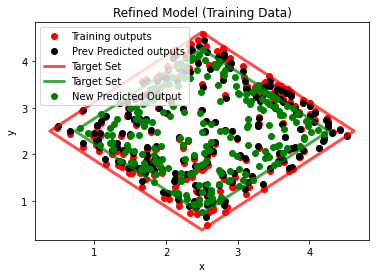

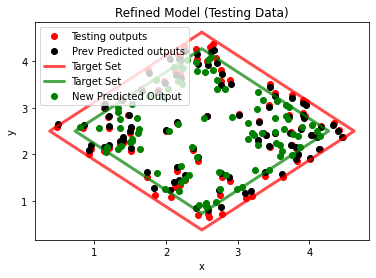

In [72]:
# ## training input
# plt.plot(x_train[:, 0], x_train[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (training)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_train[:, 0], y_train[:, 1], 'ro', label='Training outputs')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new1_train[:, 0], y_new1_train[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Testing outputs')
plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new1_test[:, 0], y_new1_test[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Testing Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

In [73]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train = squared_sum(y_train, y_new1_train, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test = squared_sum(y_test, y_new1_test, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Modified NN",round(MSE_new_nn_train,5),round(MSE_new_nn_test,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.linalg.norm(w0_new-w0_orig)
bias_error = np.linalg.norm(b0_new-b0_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))
print(w0_new-w0_orig)

MSE,Training Data,Testing Data
Original NN,0.00681,0.00604
Modified NN,0.04002,0.04546


weight_error: 1.466302741605553
bias_error: 1.012269438310207
[[ 0.5         0.5        -0.0428607  -0.09160698  0.37800023]
 [ 0.26824398 -0.40768993 -0.08891424  0.16774552  0.42580773]
 [ 0.5         0.5        -0.20349017 -0.5         0.5       ]]
